# Trabajo practico Nº2 AA1
25/10/24

Integrantes:

Bravi Eugenio B-6600/1

Nemeth Ulises N-1249/1

## Introducción
En este trabajo nos enfocamos en la predicción del clima en 10 ciudades de Australia, específicamente en predecir si va a llover o no al día siguiente.

Nos enfrentamos a algunos problemas, como valores faltantes, datos desbalanceados (con más días sin lluvia que con lluvia) y variables que varían mucho de un lugar a otro. Para lograr el objetivo, probamos diferentes estrategias y comparamos modelos.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import  roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.dummy import DummyClassifier

# Analisis Exploratorio

## Dataset wheatherAUS
Explicación de las columnas:

**Date**: Fecha del registro.

**Location**: Nombre de la ciudad.

**MinTemp**: Temperatura minima del día.

**MaxTemp**: Temperatura Maxima del día.

**Rainfall**: Cantidad de milimetros que llovio ese día.

**Evaporation**: Cantidad de evaporacion en milimetros que hubo ese día.

**Sunshine**: Cantidad de horas del sol en el día.

**WindGustDir**: Dirección de la rafaga de viento más fuerte.

**WindGustSpeed**: Velocidad en km/h de la rafaga de viento más fuerte.

**WindDir9am - WindDir3pm**: Direccion del viento en determinado horario.

**WindSpeed9am - WindSpeed3pm**: Velocidad del viento en determinado horario.

**Humidity9am - Humidity3pm**: Cantidad de humedad en determinado horario.

**Pressure9am - Pressure3pm**: Cantidad de presión atmosferica en determinado horario.

**Cloud9am - Cloud3pm**: Covertura de las nubes en determinado horario.

**Temp9am - Temp3pm**: Temperatura en determinado horario.

**RainToday**: Indica si hubo lluvias en ese día.

**RainTomorrow**: Indica si hubo lluvias en el dia siguiente.


In [47]:
df = pd.read_csv('./weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [48]:
#Buscamos 10 ciudades al azar
ciudades = pd.Series(df['Location'].unique()).sample(n=10,random_state=23)
ciudades

14     Wollongong
18       Ballarat
17    MountGinini
43         Hobart
13    Williamtown
32       Adelaide
20           Sale
8         Penrith
35        Woomera
41     SalmonGums
dtype: object

In [49]:
# Nos quedamos con las ciudades elegidas
df_ciudades = df[df['Location'].isin(ciudades)]

In [50]:
df_ciudades.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,30388.000000,30432.000000,29659.000000,11240.000000,10128.000000,29662.000000,30169.000000,30206.000000,29900.000000,30053.000000,21373.000000,21400.000000,13562.000000,12761.000000,30024.000000,30175.000000
mean,10.433645,21.197062,2.028969,6.016957,7.368385,42.056604,15.202625,18.972721,69.255084,51.862376,1017.718930,1015.681547,4.776139,4.824857,15.047828,19.782830
std,5.992917,7.587854,7.169184,6.285084,3.749717,15.082270,9.091524,9.342793,20.287892,21.959883,7.864169,7.703095,2.921765,2.799680,6.239875,7.413504
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,982.200000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,6.200000,16.300000,0.000000,2.400000,4.600000,31.000000,9.000000,13.000000,56.000000,36.000000,1012.800000,1010.800000,2.000000,2.000000,10.900000,15.100000
50%,10.300000,20.600000,0.000000,4.400000,8.000000,41.000000,15.000000,19.000000,71.000000,51.000000,1018.000000,1016.000000,6.000000,6.000000,14.900000,19.200000
75%,14.700000,25.700000,0.600000,7.400000,10.300000,50.000000,20.000000,24.000000,85.000000,67.000000,1023.100000,1020.900000,7.000000,7.000000,19.300000,24.200000
max,33.900000,48.100000,225.000000,145.000000,14.200000,135.000000,87.000000,72.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,38.600000,46.200000


In [51]:
df_ciudades.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30573 entries, 24128 to 133030
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30573 non-null  object 
 1   Location       30573 non-null  object 
 2   MinTemp        30388 non-null  float64
 3   MaxTemp        30432 non-null  float64
 4   Rainfall       29659 non-null  float64
 5   Evaporation    11240 non-null  float64
 6   Sunshine       10128 non-null  float64
 7   WindGustDir    29661 non-null  object 
 8   WindGustSpeed  29662 non-null  float64
 9   WindDir9am     28936 non-null  object 
 10  WindDir3pm     30043 non-null  object 
 11  WindSpeed9am   30169 non-null  float64
 12  WindSpeed3pm   30206 non-null  float64
 13  Humidity9am    29900 non-null  float64
 14  Humidity3pm    30053 non-null  float64
 15  Pressure9am    21373 non-null  float64
 16  Pressure3pm    21400 non-null  float64
 17  Cloud9am       13562 non-null  float64
 18  Cloud3

In [52]:
df_ciudades.isnull().sum()

Date                 0
Location             0
MinTemp            185
MaxTemp            141
Rainfall           914
Evaporation      19333
Sunshine         20445
WindGustDir        912
WindGustSpeed      911
WindDir9am        1637
WindDir3pm         530
WindSpeed9am       404
WindSpeed3pm       367
Humidity9am        673
Humidity3pm        520
Pressure9am       9200
Pressure3pm       9173
Cloud9am         17011
Cloud3pm         17812
Temp9am            549
Temp3pm            398
RainToday          914
RainTomorrow       915
dtype: int64

In [53]:
#Eliminamos las filas que tienen null en el valor a predecir.
df_ciudades = df_ciudades.dropna(subset=['RainTomorrow'])

In [54]:
location_counts = df_ciudades['Location'].value_counts()
print("Cantidad de datos por ciudad:")
print(location_counts)

Cantidad de datos por ciudad:
Location
Hobart         3188
Adelaide       3090
Ballarat       3028
Sale           3000
Woomera        2990
Wollongong     2983
Penrith        2964
SalmonGums     2955
MountGinini    2907
Williamtown    2553
Name: count, dtype: int64


Observamos que la varianza en la cantidad de datos en las distintas ciudades es menor al 10% execepto en la ciudad de Williamtown donde hay una menor cantidad de datos con respecto a las demas ciudades.

In [55]:
#Convertimos el tipo de dato de Date a fecha para poder obtener el mes
df_ciudades['Date'] = pd.to_datetime(df_ciudades['Date'])
df_ciudades['Month'] = df_ciudades['Date'].dt.month

#Dropeamos la columna date ya que no la vamos a necesitar
df_ciudades.drop('Date', axis=1, inplace=True)

## Graficos y tratamiento de valores faltantes

In [56]:
#Dividimos el dataset en set de entreamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(df_ciudades.drop('RainTomorrow', axis=1),
                                             df_ciudades['RainTomorrow'],
                                             test_size=0.2,
                                             random_state=24,
                                             shuffle=True
                                             )

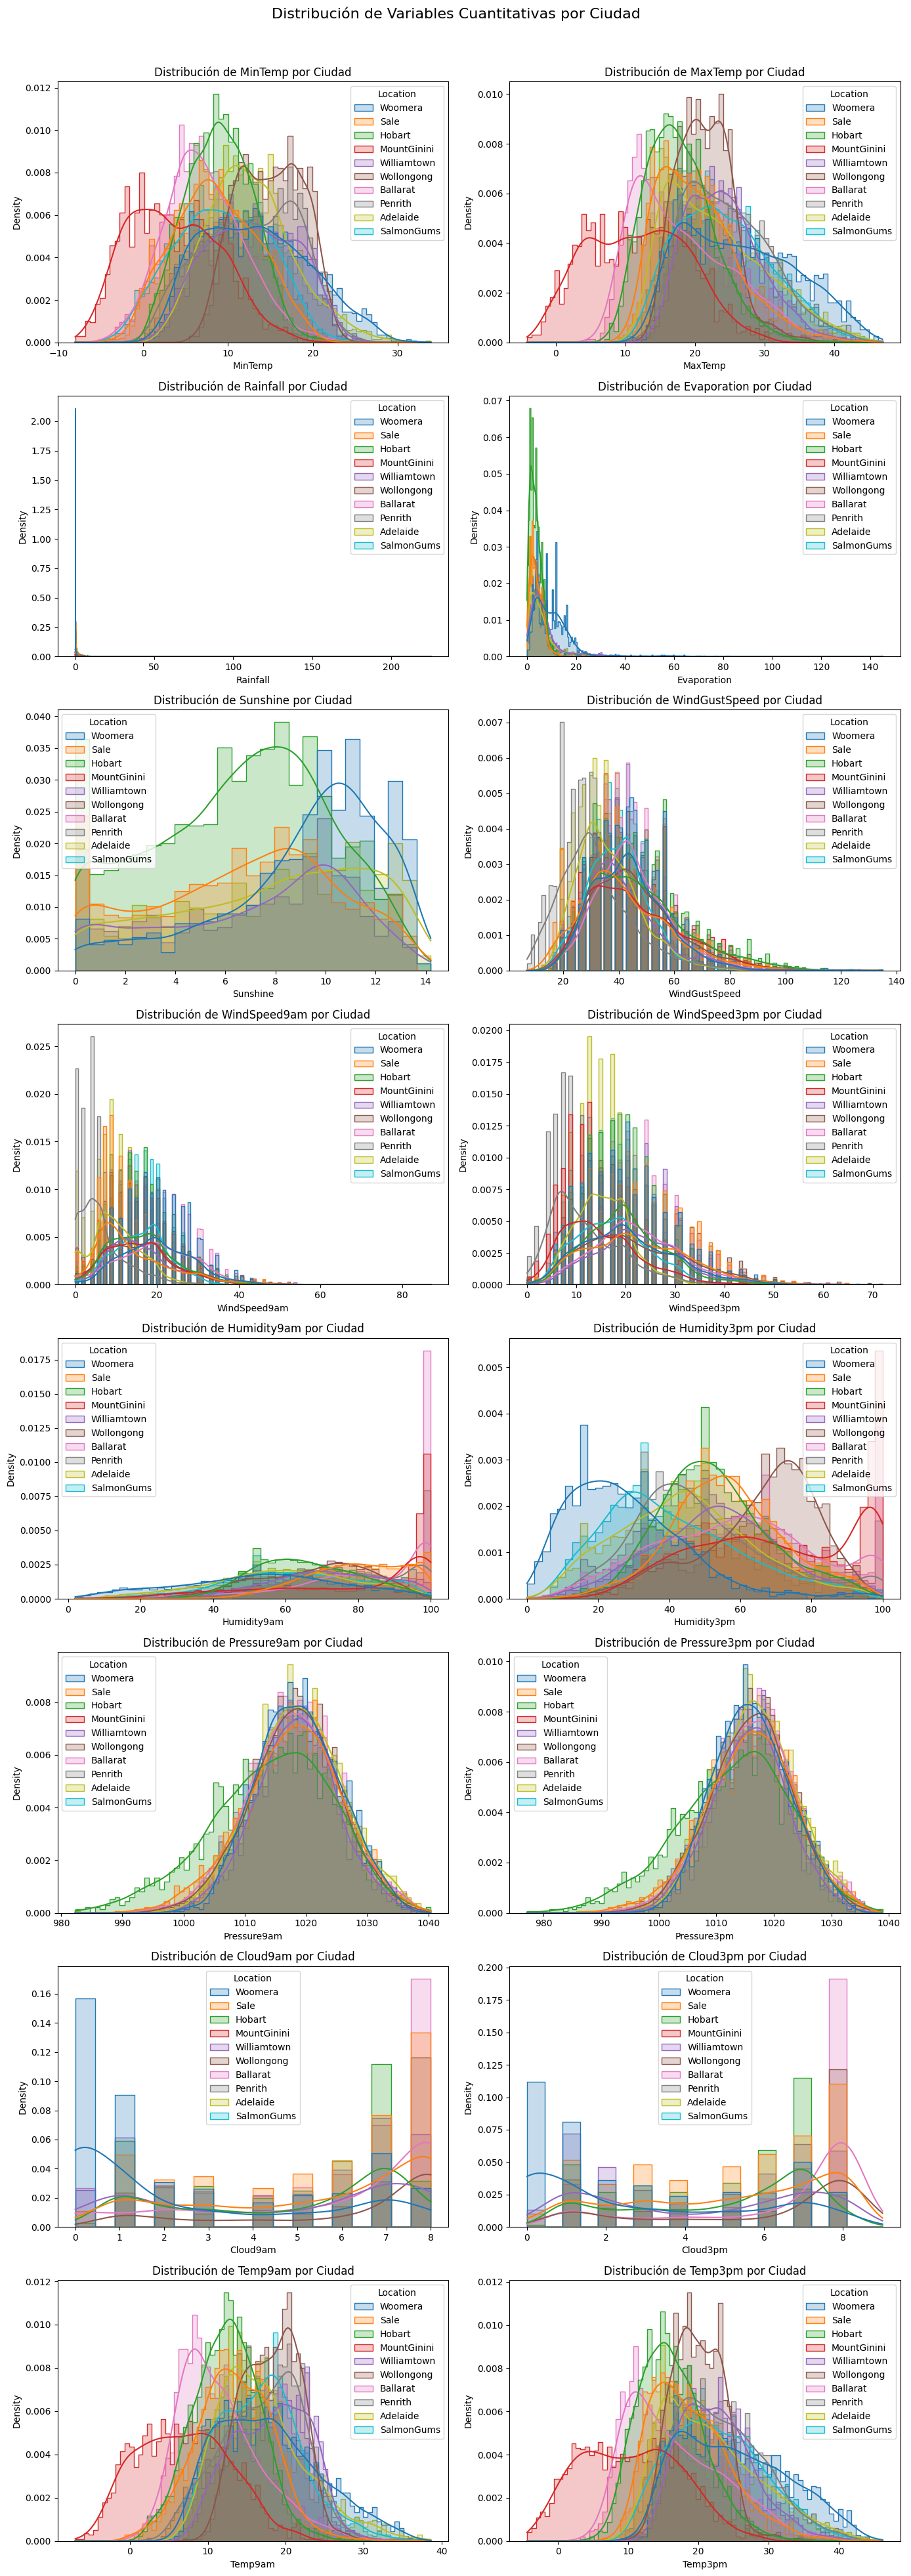

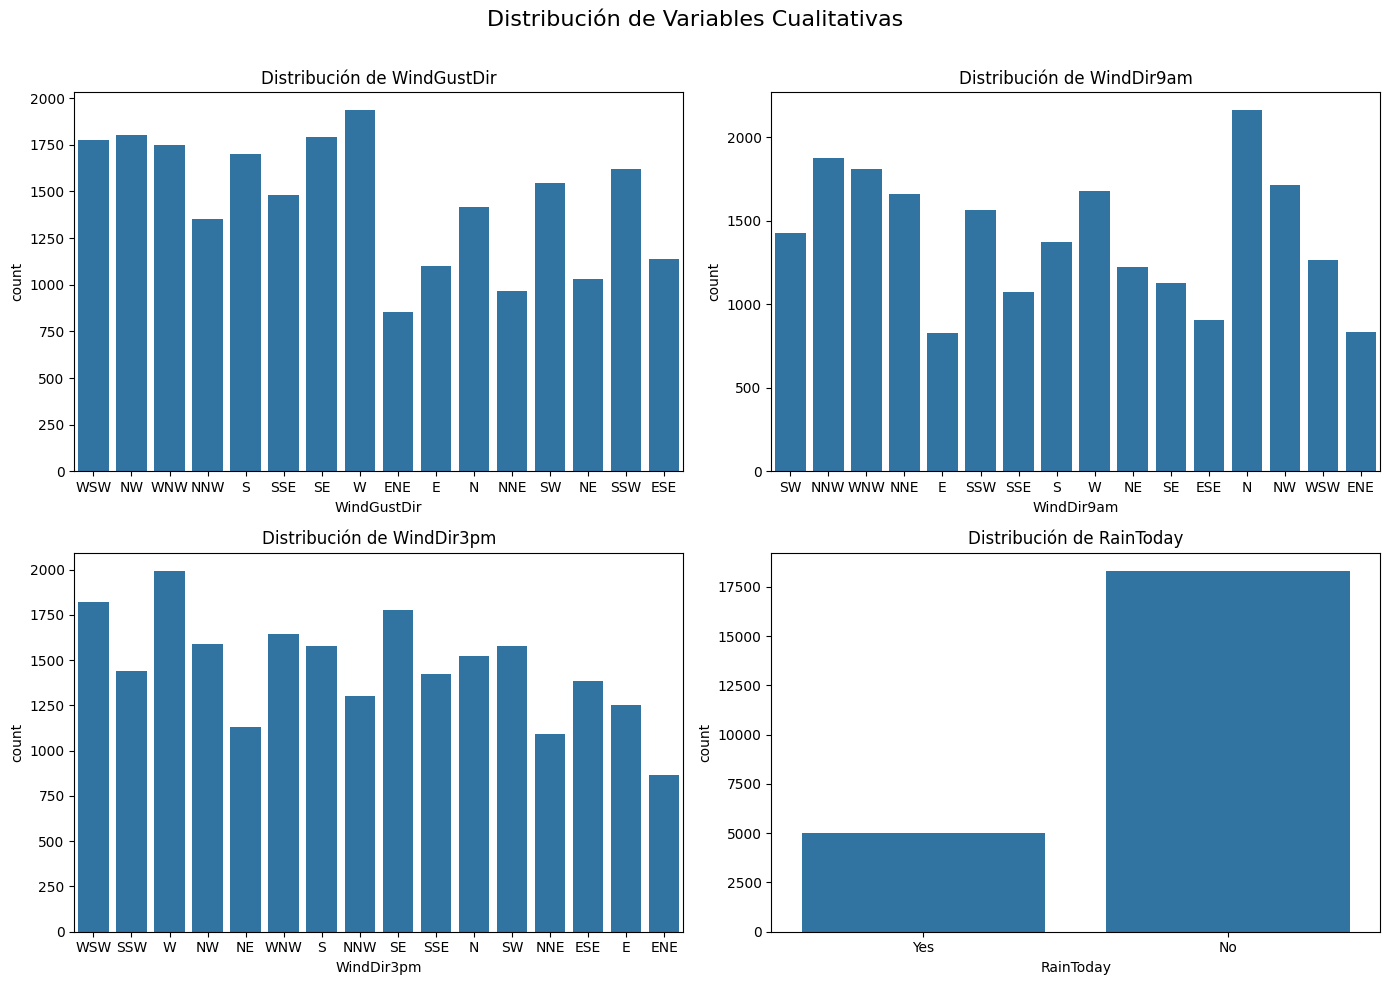

In [57]:
variables_cuantitativas = X_train.select_dtypes(include=['float64']).columns
variables_cualitativas = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
# Definimos la cantidad de filas y columnas para los subplots
n_rows_cuant = math.ceil(len(variables_cuantitativas) / 2)  # Número de filas para cuantitativas
n_rows_cual = math.ceil(len(variables_cualitativas) / 2)    # Número de filas para cualitativas

# Gráficos para variables cuantitativas
fig, axes = plt.subplots(n_rows_cuant, 2, figsize=(14, 5 * n_rows_cuant))
fig.suptitle('Distribución de Variables Cuantitativas por Ciudad', fontsize=16)
axes = axes.flatten()  # Aplanamos para indexar los ejes fácilmente

for i, var in enumerate(variables_cuantitativas):
    sns.histplot(data=X_train, x=var, hue='Location', element="step", kde=True, stat="density", ax=axes[i])
    axes[i].set_title(f'Distribución de {var} por Ciudad')

# Ocultamos gráficos vacíos en caso de que sean impares
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajuste del espaciado
plt.show()


# Gráficos para variables cualitativas
fig, axes = plt.subplots(n_rows_cual, 2, figsize=(14, 5 * n_rows_cual))
fig.suptitle('Distribución de Variables Cualitativas', fontsize=16)
axes = axes.flatten()  # Aplanamos para indexar los ejes fácilmente

for i, var in enumerate(variables_cualitativas):
    sns.countplot(data=X_train, x=var, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')

# Ocultamos gráficos vacíos en caso de que sean impares
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajuste del espaciado
plt.show()

Se observa que hay distintas densidades en los datos entre las ciudades.

Se observa que hay ciudades que no cuentan con valores para algunas variables.

## Tratamiento de valores faltantes


In [58]:
group_ciudades_mes = X_train[variables_cuantitativas].groupby([X_train['Location'], X_train['Month']]).median()

for location, month in group_ciudades_mes.index:
    # Obtenemos las medianas para esta combinación de Location y Month
    medianas = group_ciudades_mes.loc[(location, month)]

    mask = (X_train['Location'] == location) & (X_train['Month'] == month)
    mask_test = (X_test['Location'] == location) & (X_test['Month'] == month)
    X_train.loc[mask, variables_cuantitativas] = X_train.loc[mask, variables_cuantitativas].fillna(medianas)
    X_test.loc[mask_test, variables_cuantitativas] = X_test.loc[mask_test, variables_cuantitativas].fillna(medianas)

In [59]:
group_mes = X_train[variables_cuantitativas].groupby(X_train['Month']).median()

for month in group_mes.index:
    # Obtenemos las medianas para Month
    medianas = group_mes.loc[(month)]

    mask = (X_train['Month'] == month)
    mask_test = (X_test['Month'] == month)
    X_train.loc[mask, variables_cuantitativas] = X_train.loc[mask, variables_cuantitativas].fillna(medianas)
    X_test.loc[mask_test, variables_cuantitativas] = X_test.loc[mask_test, variables_cuantitativas].fillna(medianas)

In [60]:
group_ciudades_mes = X_train[variables_cualitativas].groupby([X_train['Location'], X_train['Month']]).apply(lambda x: x.mode().iloc[0])
for location, month in group_ciudades_mes.index:
    # Obtenemos las medianas para esta combinación de Location y Month
    modas = group_ciudades_mes.loc[(location, month)]

    mask = (X_train['Location'] == location) & (X_train['Month'] == month)
    mask_test = (X_test['Location'] == location) & (X_test['Month'] == month)
    X_train.loc[mask, variables_cualitativas] = X_train.loc[mask, variables_cualitativas].fillna(modas)
    X_test.loc[mask_test, variables_cualitativas] = X_test.loc[mask_test, variables_cualitativas].fillna(modas)

In [61]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0


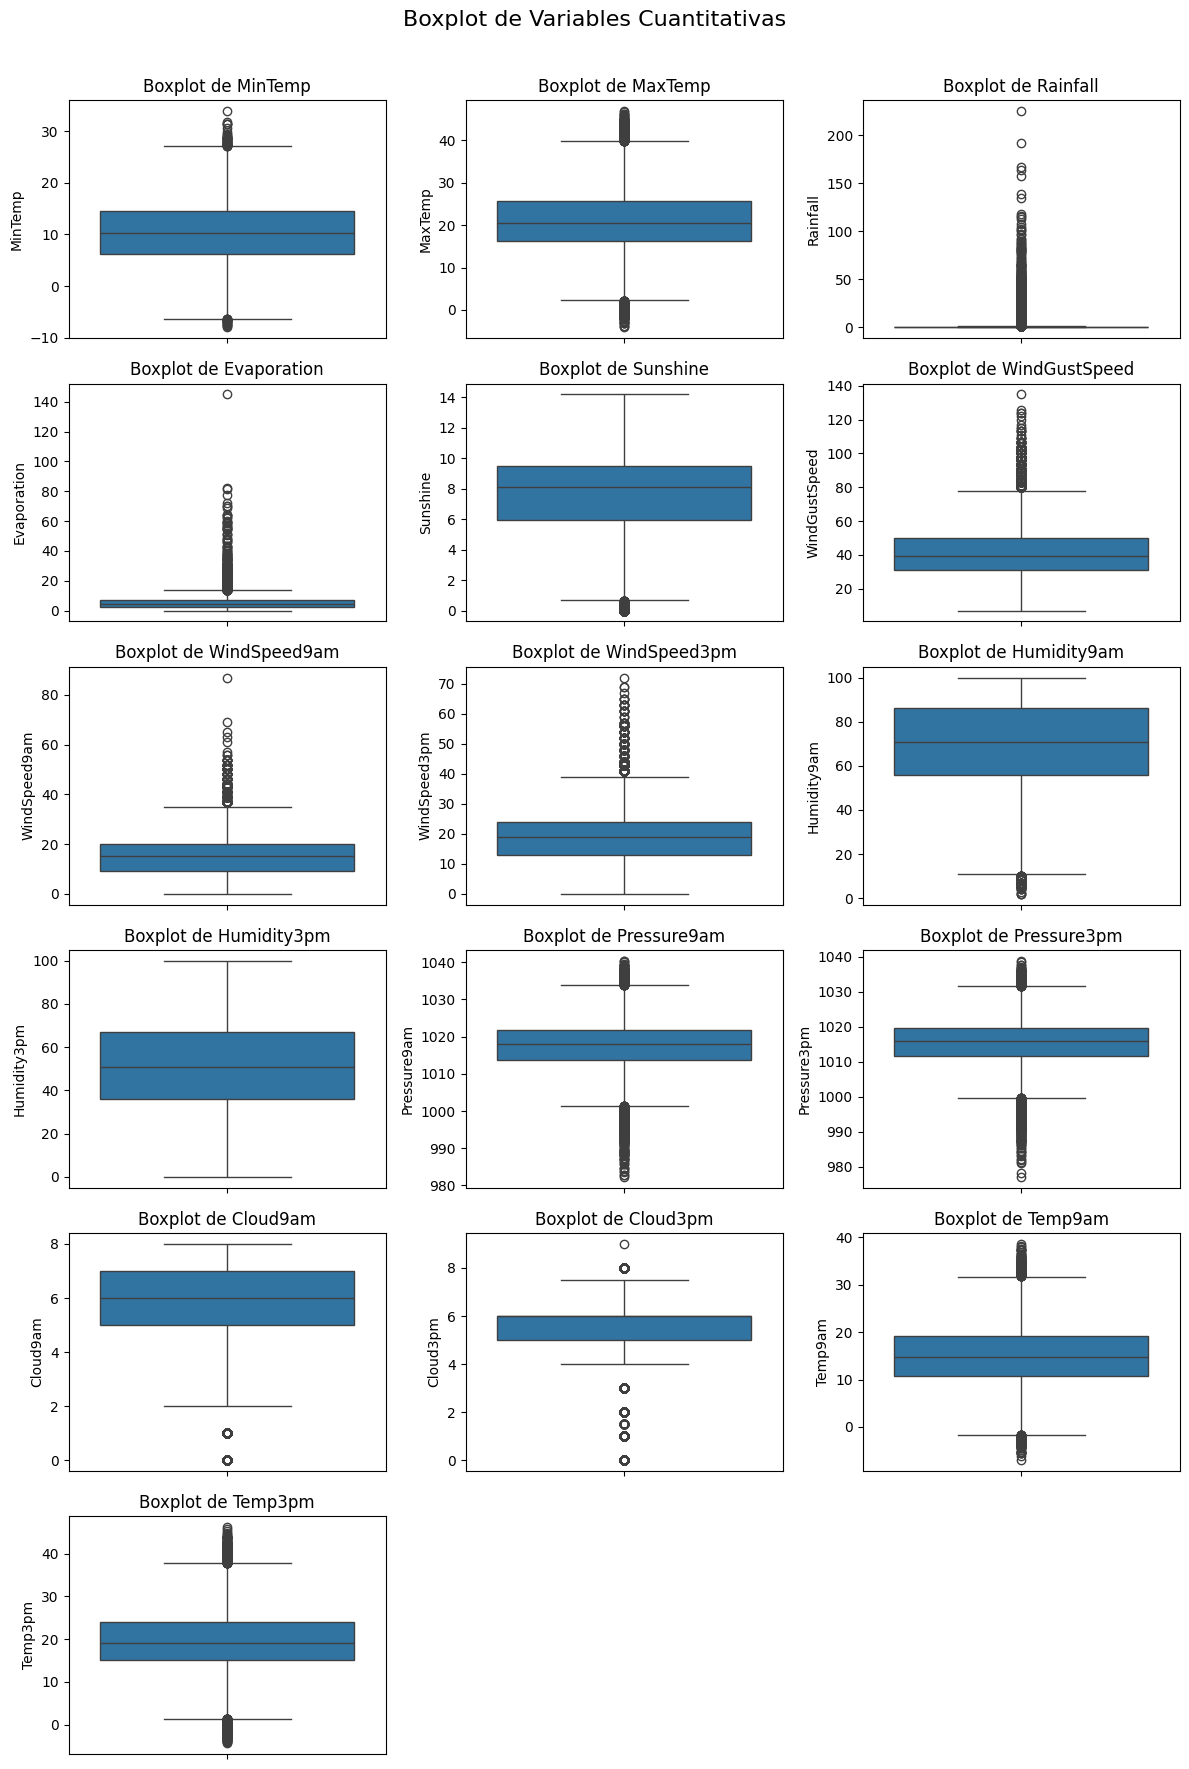

In [62]:
n_cols = 3  # 3 gráficos por fila
n_rows = math.ceil(len(variables_cuantitativas) / n_cols)  # Calculamos el número de filas

# Creamos los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
fig.suptitle('Boxplot de Variables Cuantitativas', fontsize=16)
axes = axes.flatten()  # Aplanamos para indexar fácilmente los subplots

# Generamos un boxplot para cada variable cuantitativa
for i, var in enumerate(variables_cuantitativas):
    sns.boxplot(data=X_train, y=var, ax=axes[i])
    axes[i].set_title(f'Boxplot de {var}')

# Eliminamos los subplots vacíos si el número de variables no es múltiplo de 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajuste del espaciado
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

No utilizamos KNN Inputer debido a la alta demanda computacional debido a la gran cantidad de datos y columnas que tiene este dataset.

Completamos los valores faltantes de las variables cuantitativas con la mediana de cada ciudad en cada mes. En algunas variables algunas ciudades no contaban con ningun dato en ese caso completamos con la mediana del mes de todas la ciudades.

A las variables cualitativas las completamos con la moda de cada ciudad en cada mes.

Tambien decidimos quedarnos con todos los valores outliers ya que creemos que son casos realistas y que pueden suceder por lo que hay que preservarlos para que el modelo sea mas robusto y preciso.

## Codificación de variables categoricas

In [63]:
# Pasamos RainToday a boolean
X_train['RainToday'] = X_train['RainToday'].map({'Yes': 1, 'No': 0})
X_test['RainToday'] = X_test['RainToday'].map({'Yes': 1, 'No': 0})
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

In [64]:
# Location a Latitud (float64) y Longitud (float64)
location_coordenadas = {
    'Wollongong': [-34.43305,150.88305 ],
    'Ballarat': [-37.56622, 143.84957],
    'MountGinini': [-35.28346, 149.12807],
    'Hobart': [-42.88333,147.31666 ],
    'Williamtown': [-32.80899, 151.83899],
    'Adelaide': [-34.92866, 138.59863],
    'Sale': [-33.86785, 151.20732],
    'Penrith': [-33.75111, 150.69416],
    'Woomera': [-31.16563, 136.81926],
    'SalmonGums': [-32.98207, 121.64416]
}

# Creamos nuevas columnas 'Latitud' y 'Longitud' mapeando con location_coordenadas
X_train['Latitud'] = X_train['Location'].map(lambda loc: location_coordenadas[loc][0])
X_train['Longitud'] = X_train['Location'].map(lambda loc: location_coordenadas[loc][1])
X_test['Latitud'] = X_test['Location'].map(lambda loc: location_coordenadas[loc][0])
X_test['Longitud'] = X_test['Location'].map(lambda loc: location_coordenadas[loc][1])

# Eliminamos la columna 'Location'
X_train = X_train.drop(columns=['Location'])
X_test = X_test.drop(columns=['Location'])

In [65]:
# Las direcciones del viento a angulos (float64)
angulos = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}
for column in ['WindGustDir','WindDir9am','WindDir3pm']:
    X_train[column] = X_train[column].map(angulos)
    X_test[column] = X_test[column].map(angulos)

## Correlación

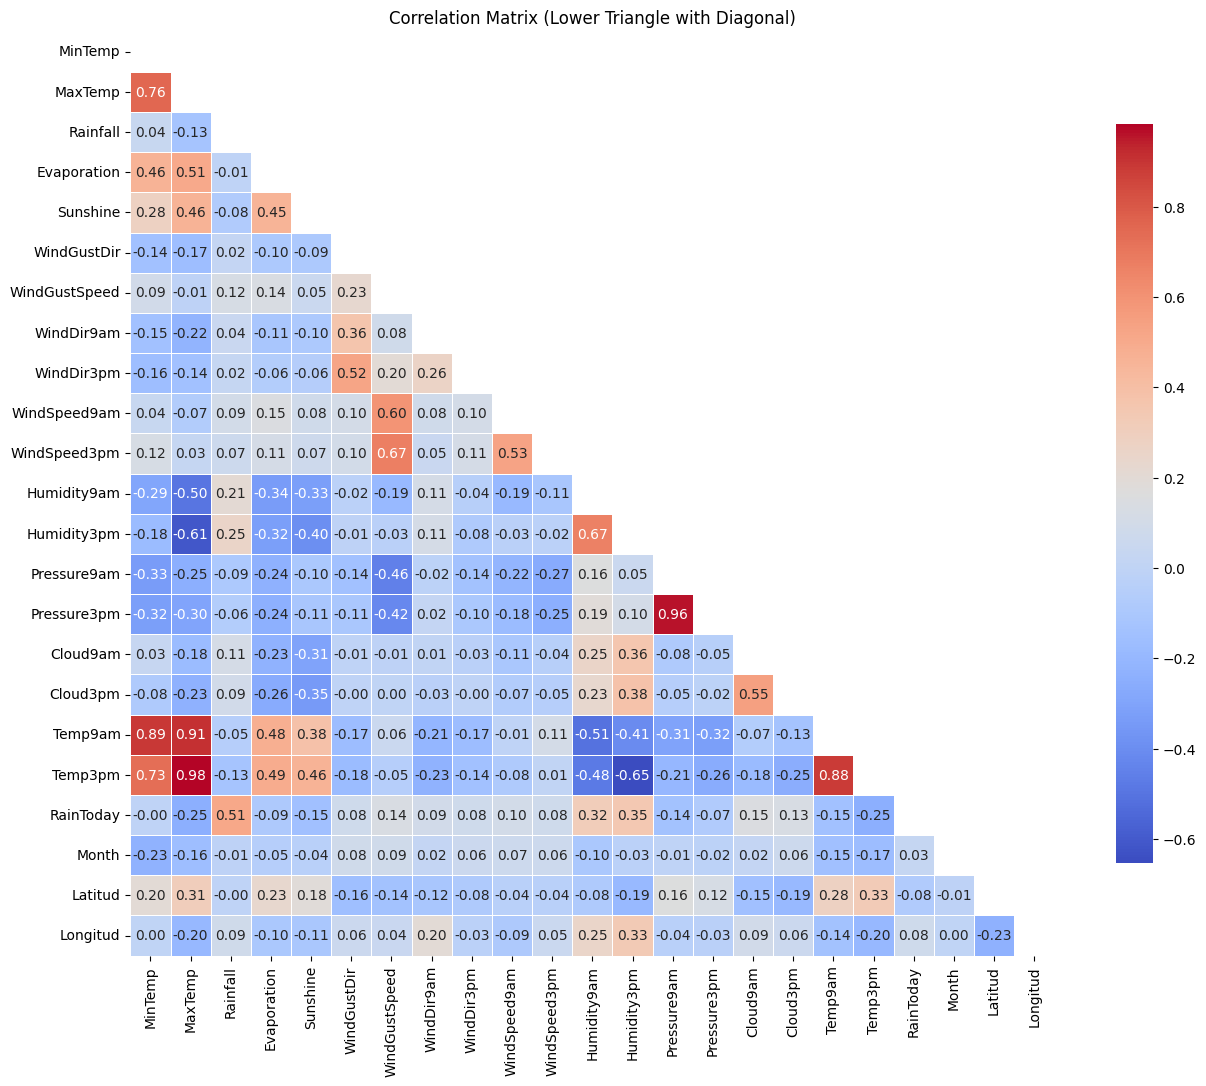

In [66]:
# Creamos heatmap con la matriz de correlacion
correlation_matrix = X_train.corr()

# Creamos una máscara para ocultar solo la mitad superior (incluyendo los elementos estrictamente encima de la diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficamos la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            linewidths=0.5, cbar_kws={"shrink": 0.8}, square=True)
plt.title("Correlation Matrix (Lower Triangle with Diagonal)")
plt.show()

Se observa que las variables que tienen mediciones en distintos horarios tienden a tener una alta correlación entre ellas. por ejemplo la temperatura a las 3pm tiene una correlacion de 0.98 con la temperatura maxima del dia.

Tambien se observa que la temperatura y la humedad estan medianamente correlacionadas negativamente.

La evaporacion y las horas de sol estan medianamente correlacionadas con la temperatura.



##Balance del modelo

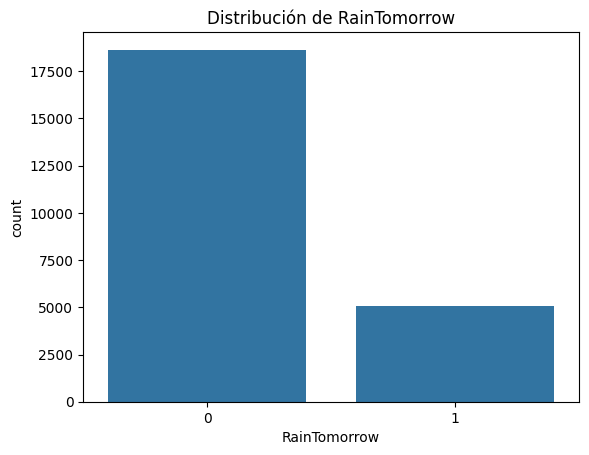

RainTomorrow
0    79.0
1    21.0
Name: count, dtype: float64


In [67]:
# Visualizamos el balance
sns.countplot(x='RainTomorrow', data=y_train.to_frame())
plt.title('Distribución de RainTomorrow')
plt.show()
print(round(y_train.value_counts() / len(y_train) *100,0))

El dataset no esta balanceado debido a que casi el 80% de los datos son de NO lluvia. Esto prodria significar en que el modelo vaya a aprender a predecir la clase mayoritaria, para evitar eso se tendria que aplicar tecnicas de balanceo.

# Regresión Logística

In [68]:
modelo_base = make_pipeline(RobustScaler(), LogisticRegression(max_iter=150,random_state=42))
modelo_base.fit(X_train,y_train)

modelo_balanceado = make_pipeline(RobustScaler(), LogisticRegression(max_iter=150,random_state=42, class_weight='balanced'))
modelo_balanceado.fit(X_train,y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=150,
                                    random_state=42))])

Utilizamos el RobustScaler debido a que decidimos conservar los valores atipicos.

## Modelo Base

In [69]:
def metricas(nombre_modelo,modelo,y_pred):
  metrics = {
    "Modelo": [
        nombre_modelo
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred)
    ],
    "Precision (No llueve)": [
      precision_score(y_test, y_pred, pos_label=0)
    ],
    "Precision (llueve)": [
      precision_score(y_test, y_pred, pos_label=1)
    ],
    "Recall (No llueve)": [
      recall_score(y_test, y_pred, pos_label=0)
    ],
    "Recall llueve": [
      recall_score(y_test, y_pred, pos_label=1)
    ],
    "F1 Score (No llueve)": [
      f1_score(y_test, y_pred, pos_label=0)
    ],
    "F1 Score (llueve)": [
      f1_score(y_test, y_pred, pos_label=1)
    ],
    "AUC Roc (No llueve)": [
      1-roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])
    ],
    "AUC Roc (llueve)": [
      roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])
    ]
  }
  return pd.DataFrame(metrics)

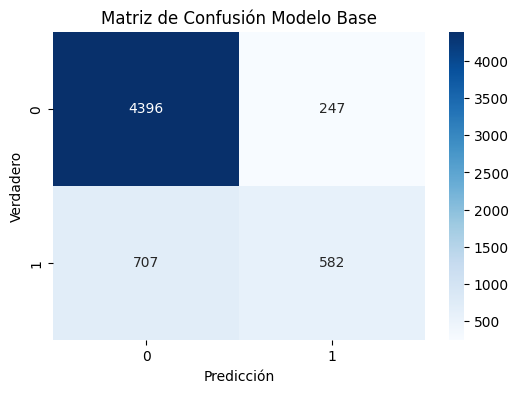

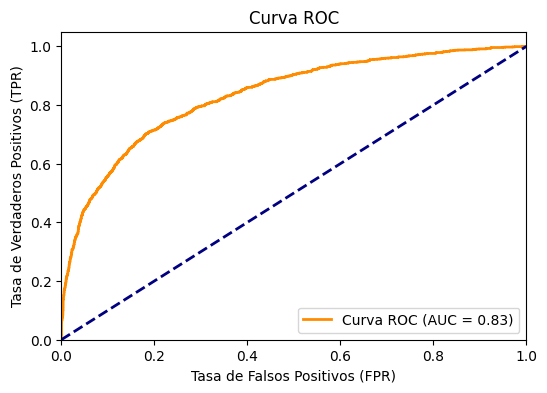

,Modelo,Accuracy,Precision (No llueve),Precision (llueve),Recall (No llueve),Recall llueve,F1 Score (No llueve),F1 Score (llueve),AUC Roc (No llueve),AUC Roc (llueve)
0,Modelo Base,0.839177,0.861454,0.702051,0.946802,0.451513,0.902114,0.549575,0.166657,0.833343


In [70]:
y_pred_base = modelo_base.predict(X_test)
cf_m_base = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_m_base, annot=True, fmt="", cmap='Blues')
plt.title('Matriz de Confusión Modelo Base')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Obtenemos las probabilidades de predicción del modelo
y_probs = modelo_base.predict_proba(X_test)[:, 1]

# Calculamos la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Metricas
metricas_base = metricas('Modelo Base',modelo_base,y_pred_base)
metricas_base

TN cuando el modelo predice que no llueve y no llueve.

FN cuando el modelo precice que no llueve y llueve.

TP cuando el modelo predice que llueve y llueve.

FP cuando el modelo predice que llueve y no llueve.

Se observa que el modelo predice mejor cuando no llueve esto se debe a que tiende a predecir que no llueve por que los datos estan desbalanceados.

En el F1 score se ve claramente como el modelo clasifica correctamente cuando no llueve (0.90) mientras que clasifica muy pobremente cuando llueve (0.54)

## Modelo Balanceado

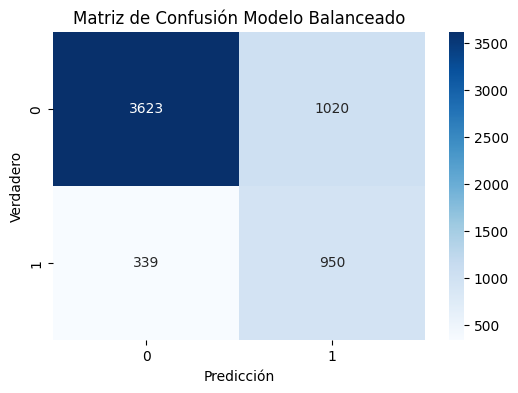

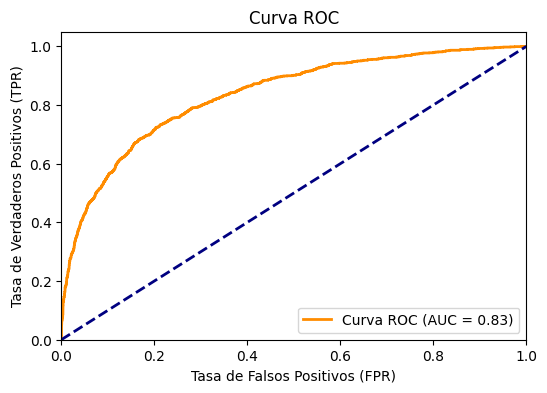

,Modelo,Accuracy,Precision (No llueve),Precision (llueve),Recall (No llueve),Recall llueve,F1 Score (No llueve),F1 Score (llueve),AUC Roc (No llueve),AUC Roc (llueve)
0,Modelo Balanceado,0.770904,0.914437,0.482234,0.780314,0.737005,0.842069,0.583001,0.165581,0.834419


In [71]:
y_pred_balanceado = modelo_balanceado.predict(X_test)
cf_m_balanceado = confusion_matrix(y_test, y_pred_balanceado)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_m_balanceado, annot=True, fmt="", cmap='Blues')
plt.title('Matriz de Confusión Modelo Balanceado')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Obtenemos las probabilidades de predicción del modelo
y_probs = modelo_balanceado.predict_proba(X_test)[:, 1]

# Calculamos la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Metricas
metricas_balanceado = metricas('Modelo Balanceado',modelo_balanceado,y_pred_balanceado)
metricas_balanceado

En el modelo balanceado se observa como disminuye la cantidad de FN y aumentan los TP pero a cambio disminuye considerablemente los TN y aumentan los FP.

## Modelo Base con regularización

In [72]:
modelo_base_reg = make_pipeline(RobustScaler(), LogisticRegression(max_iter=2000,random_state=42,penalty='l1', C=1, solver='saga'))
modelo_base_reg.fit(X_train,y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=2000, penalty='l1',
                                    random_state=42, solver='saga'))])

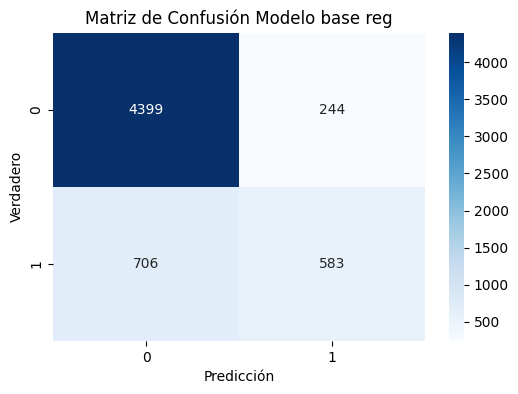

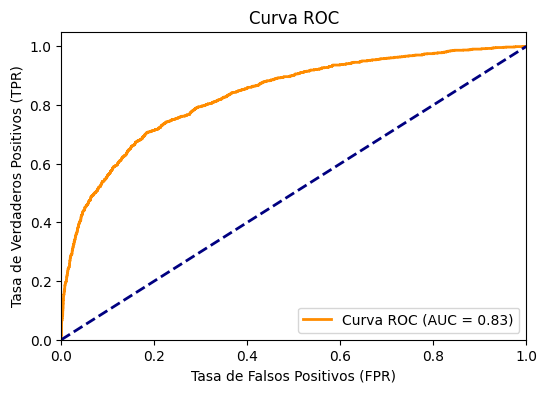

,Modelo,Accuracy,Precision (No llueve),Precision (llueve),Recall (No llueve),Recall llueve,F1 Score (No llueve),F1 Score (llueve),AUC Roc (No llueve),AUC Roc (llueve)
0,Modelo base reg,0.839852,0.861704,0.704958,0.947448,0.452289,0.902544,0.55104,0.16664,0.83336


In [73]:
y_pred_base_reg = modelo_base_reg.predict(X_test)
cf_m_base_reg = confusion_matrix(y_test, y_pred_base_reg)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_m_base_reg, annot=True, fmt="", cmap='Blues')
plt.title('Matriz de Confusión Modelo base reg')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Obtenemos las probabilidades de predicción del modelo
y_probs = modelo_base_reg.predict_proba(X_test)[:, 1]

# Calculamos la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Metricas
metricas_base_reg = metricas('Modelo base reg',modelo_base_reg,y_pred_base_reg)
metricas_base_reg

In [74]:
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)
modelo_oversampled = make_pipeline(RobustScaler(), LogisticRegression(max_iter=150,random_state = 42))
modelo_oversampled.fit(X_oversampled,y_oversampled)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=150, random_state=42))])

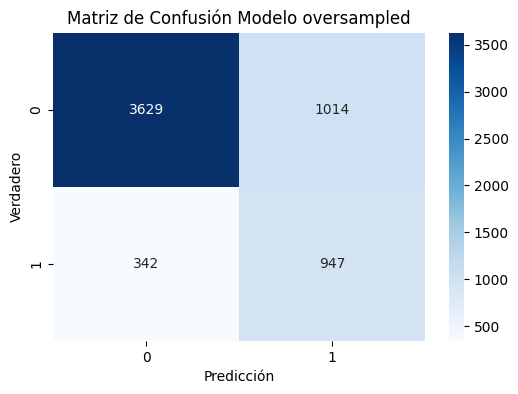

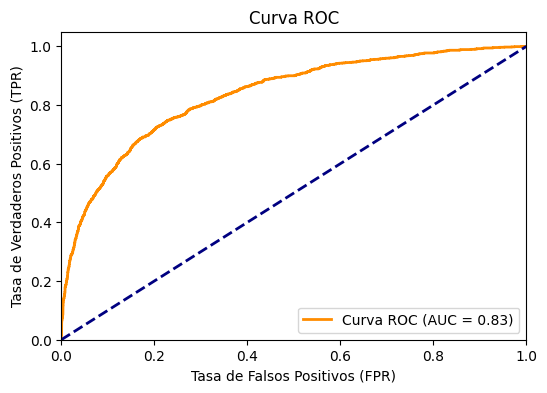

,Modelo,Accuracy,Precision (No llueve),Precision (llueve),Recall (No llueve),Recall llueve,F1 Score (No llueve),F1 Score (llueve),AUC Roc (No llueve),AUC Roc (llueve)
0,Modelo oversampled,0.771409,0.913876,0.482917,0.781607,0.734678,0.842582,0.582769,0.165484,0.834516


In [75]:
y_pred_over = modelo_oversampled.predict(X_test)
cf_m_over = confusion_matrix(y_test, y_pred_over)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_m_over, annot=True, fmt="", cmap='Blues')
plt.title('Matriz de Confusión Modelo oversampled')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Obtenemos las probabilidades de predicción del modelo
y_probs = modelo_oversampled.predict_proba(X_test)[:, 1]

# Calculamos la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Metricas
metricas_over = metricas('Modelo oversampled',modelo_oversampled,y_pred_over)
metricas_over

## Modelo Random

In [76]:
modelo_random = make_pipeline(RobustScaler(), DummyClassifier(strategy="stratified",random_state=42))
modelo_random.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('dummyclassifier',
                 DummyClassifier(random_state=42, strategy='stratified'))])

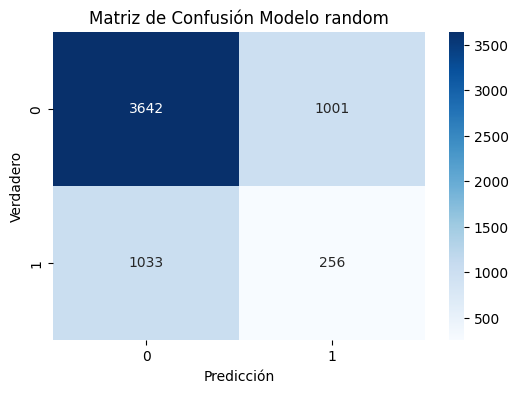

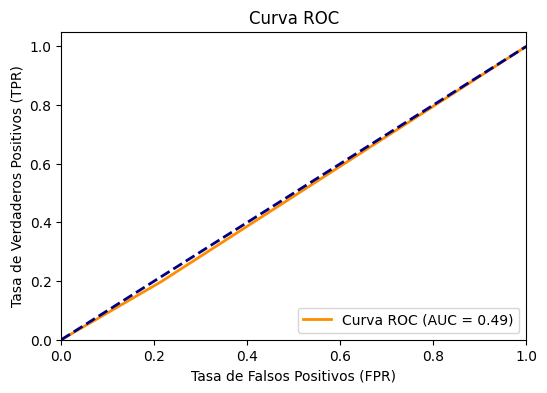

,Modelo,Accuracy,Precision (No llueve),Precision (llueve),Recall (No llueve),Recall llueve,F1 Score (No llueve),F1 Score (llueve),AUC Roc (No llueve),AUC Roc (llueve)
0,Modelo random,0.657114,0.779037,0.20366,0.784407,0.198604,0.781713,0.2011,0.508495,0.491505


In [77]:
y_pred_random = modelo_random.predict(X_test)
cf_m_random = confusion_matrix(y_test, y_pred_random)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_m_random, annot=True, fmt="", cmap='Blues')
plt.title('Matriz de Confusión Modelo random')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Obtenemos las probabilidades de predicción del modelo
y_probs = modelo_random.predict_proba(X_test)[:, 1]

# Calculamos la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Metricas
metricas_random = metricas('Modelo random',modelo_random,y_pred_random)
metricas_random

## Comparación de modelos

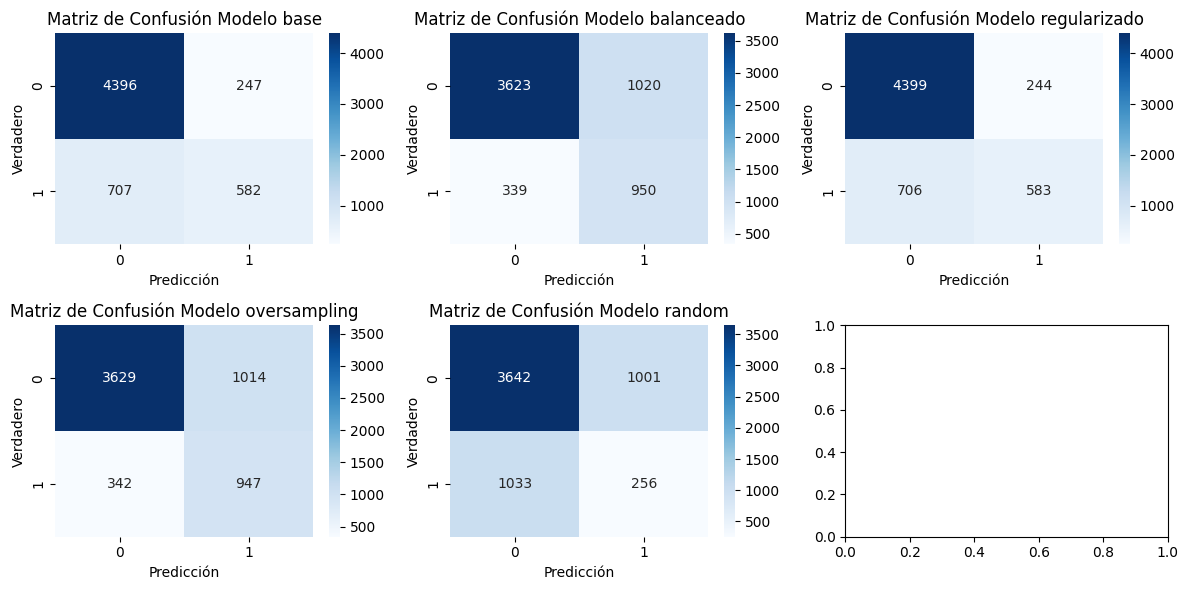

In [78]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Títulos para cada subplot
titles = ['Modelo base', 'Modelo balanceado', 'Modelo regularizado', 'Modelo oversampling', 'Modelo random']
cf_matrices = [cf_m_base, cf_m_balanceado, cf_m_base_reg, cf_m_over,cf_m_random]
# Iteraramos sobre cada subplot y creamos un heatmap
for i, ax in zip(range(5), axes.flat):
    sns.heatmap(cf_matrices[i], annot=True, fmt="", cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión {titles[i]}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Verdadero')

# Ajustamos la visualización de los subplots
plt.tight_layout()
plt.show()

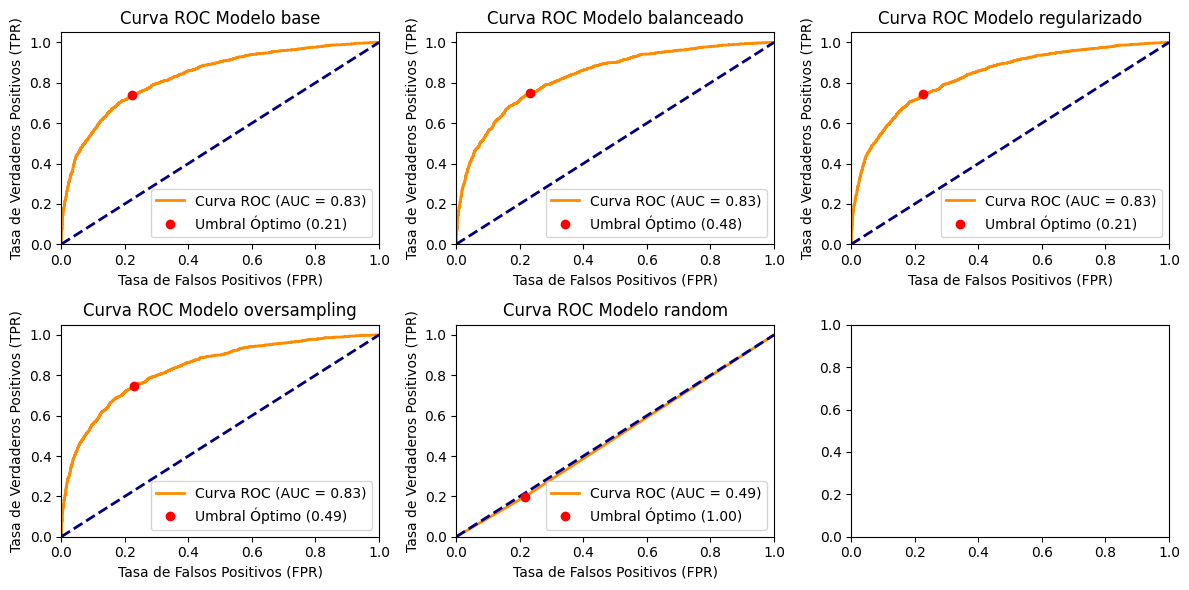

In [79]:
modelo = [modelo_base, modelo_balanceado, modelo_base_reg, modelo_oversampled, modelo_random]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in zip(range(5), axes.flat):
    # Obtenemos las probabilidades de predicción del modelo
    y_probs = modelo[i].predict_proba(X_test)[:, 1]

    # Calculamos la curva ROC y el AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Calculamos el punto óptimo de umbral
    distancias = (fpr**2 + (1 - tpr)**2)**0.5
    indice_optimo = distancias.argmin()
    fpr_optimo, tpr_optimo = fpr[indice_optimo], tpr[indice_optimo]
    umbral_optimo = thresholds[indice_optimo]

    # Graficamos la curva ROC en el subplot específico
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Graficamos el punto óptimo de umbral
    ax.plot(fpr_optimo, tpr_optimo, 'ro', label=f'Umbral Óptimo ({umbral_optimo:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(f'Curva ROC {titles[i]}')
    ax.legend(loc="lower right")

# Ajustamos el layout para que no haya solapamiento
plt.tight_layout()
plt.show()

In [80]:
# Mostramos una tabla comparativa de los modelos
comparacion = pd.concat([metricas_base, metricas_balanceado, metricas_base_reg, metricas_over,metricas_random], ignore_index=True)
comparacion

,Modelo,Accuracy,Precision (No llueve),Precision (llueve),Recall (No llueve),Recall llueve,F1 Score (No llueve),F1 Score (llueve),AUC Roc (No llueve),AUC Roc (llueve)
0,Modelo Base,0.839177,0.861454,0.702051,0.946802,0.451513,0.902114,0.549575,0.166657,0.833343
1,Modelo Balanceado,0.770904,0.914437,0.482234,0.780314,0.737005,0.842069,0.583001,0.165581,0.834419
2,Modelo base reg,0.839852,0.861704,0.704958,0.947448,0.452289,0.902544,0.551040,0.166640,0.833360
3,Modelo oversampled,0.771409,0.913876,0.482917,0.781607,0.734678,0.842582,0.582769,0.165484,0.834516
4,Modelo random,0.657114,0.779037,0.203660,0.784407,0.198604,0.781713,0.201100,0.508495,0.491505


# Conclusiones
Los dos modelos no balanceados tienen resultados similares, estos tienen un mejor recall en la clase negativa (no llueve) en comparación a la clase positiva (llueve), esto es debido al desbalance que hay en los datos.

Los modelos con balance de datos por otro lado tienen un recall similar tanto para la clase negativa como para la positiva pero si F1 score es solo levemente mejor que el de los modelos no balanceados para la clase positiva.

El modelo random es el peor de todos ya que hace las clasificaciones al azar por ese motivo tiene un rendimiento muy bajo, ya que no puede encontrar relaciones en los datos.

El AUC de todos los modeles expecto el random dieron resultados similares (aprox 0.83) un numero bastante cercano a 1 lo que indica un modelo con buen rendimiento en clasificación. Tambien se puede observar que el umbral optimo para los modelos balanceados es aprox 0.5 mientras que para los modelos no balanceados es de aprox 0.2, por lo que se puede decir que un umbral de 0.5 no es siempre el mas optimo.